In [0]:
import numpy as np
import scipy as sc
import matplotlib.pyplot as plt

#Esto es para crar un dataset con una distribucion circular
from sklearn.datasets import make_circles

500
500


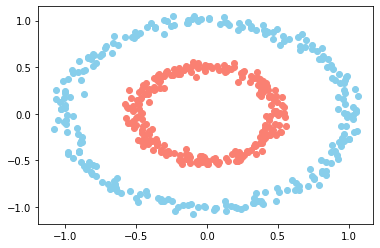

In [0]:
#n es el numero de registros en nuestros datos
n=500
#p la cantidad de propiedades/caracteristicas de cada uno de los registros 
p=2

#Crear el dataset
# Donde X es el array que contiene las dos propiedades
# Donde Y es el array que contiene el resultado de aplicar la funcion, 
# Y es 0 si pertenece a un circulo o 1 si pertenece al otro

#Factor es la distancia entre ambos circulos
#Noise es para modificar la uniformidad, modificando este valor los valores no son uniformes, pruebalo
X, Y = make_circles (n_samples=n, factor=0.5, noise=0.04)

#Corrigiendo Y, porque la funcion devuelve una serie de numeros y no un array, que es lo que queremos
Y = Y[:, np.newaxis]

print (len(X))
print (len(Y))
# Plotear solo los puntos que pertenecen al circulo 0
plt.scatter(X[Y[:,0]==0,0],X[Y[:,0]==0,1], c="skyblue")

# Plotear solo los puntos que pertenecen al circulo 1
plt.scatter(X[Y[:,0]==1,0],X[Y[:,0]==1,1], c="salmon")

plt.show()

El objetivo es que la red neuronal, separe en dos (clases) toda esta nube de puntos

In [0]:
#Una forma de pensar es ver cada capa es un modulo
#Dentro de una misma capa se realizaran las mismas operaciones
#El MODULO PRINCIPAL en una RN es es "la capa"

class NeuralLayer ():
  def __init__(self, connections, neurons, activationFunction, deriv_activationFunction):
    self.activationFunction = activationFunction
    self.deriv_activationFunction = deriv_activationFunction
    # bias = sesgo, es un array, del tamano de la cantidad de neuronas
    # de valores entre -1 y 1 (normalizado), por eso multiplicamos el valor * 2 y le quitamos 1
    self.bias = np.random.rand(1, neurons) * 2 -1

    #Este es el la matriz de pesos, de  connections x neurons
    self.w =  np.random.rand(connections, neurons) * 2 -1


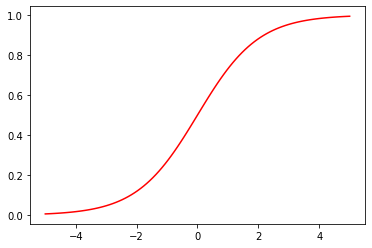

In [0]:
# Estas son las diferentes funciones de activacion que usaremos
sigm =  lambda x: 1/ (1 + np.e ** (-x))
# generamos un vector de 100 elementos de valores entre -5 y 5
_x = np.linspace (-5,5, 100)
#generamos la grafica
plt.plot(_x,sigm(_x), 'r')

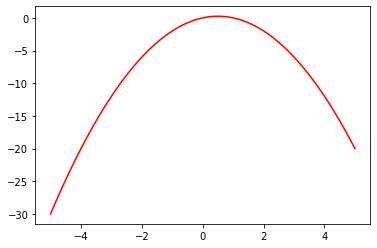

In [0]:
# Necesitaremos la derivada de la funcion de activacion, para el algoritmo de backpropagation
# en este caso dde la funcion sigmoide
deriv_sigm = lambda x: x* (1-x)
plt.plot(_x,deriv_sigm(_x), 'r')

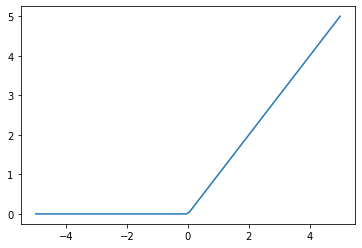

In [0]:
# otra funcion de activacion
relu = lambda x: np.maximum (0, x)
plt.plot(_x,relu(_x))

In [0]:
# layer 0
l0 = NeuralLayer (p, 4, sigm, deriv_sigm)
# layer 1
l1 = NeuralLayer (4, 8, sigm, deriv_sigm)

# Definimos una variable que nos permitira modificar la topologia de la RNN de manera dinamica
# Contiene la cantidad de neuronas que tendra cada capa
# La capa final tiene una sola neurona, porque el resultado que queremos obtener es binario
# Es decir 0 = pertenede al primer conjunto de datos o 1 = pertenece al segundo conjunto
topology = [p, 4, 8, 16, 8, 4, 1]

# Tambien podriamos tener otro vector que diga que funciones de activacion usaremos en cada capa
# functions = []
# Que learning rate usaremos por cada capa
# learning_rate = []
# Estos se llaman los hiper-parametros
# Por simplicidad mantendremos topology simplemente en base al numero de neuronas por capa
# Tambien por simplicidad definimos que todas las capas tendran la misma funcion de activacion, esto puede cambiarse
def createNeuralNetwork (topology, activation_function, deriv_activation_function):
  nn = []
  #esta forma es sin manipular el array
  # for i, n_neurons in enumerate(topology):
  #   if (i+1 < len(topology)):
  #     nn.append (NeuralLayer(connections=n_neurons, neurons=topology[i+1]), activation_function)
  for i, n_neurons in enumerate(topology [:-1]): #descartando el ultimo elemento para evitar el if interno
    print (n_neurons, topology[i])
    nn.append (NeuralLayer(connections=topology[i], neurons=topology[i+1], activationFunction= activation_function, deriv_activationFunction=deriv_activation_function))
  return nn

createNeuralNetwork (topology, sigm, deriv_sigm)

2 2
4 4
8 8
16 16
8 8
4 4


In [0]:
#Creando la logica de entrenamiento
# Este tiene proceso tiene tres pasos/elementos
# 1) Un procesamiento hacia adelante
# Mostrarle a la RNN un tipo de entrada y la salida que quiero obtener, 
# la RNN procesara estos dos elementos por todas sus capas y todas sus neuronas, 
# ejecutando sumas ponderadas y funciones de activacion y retornara un valor
# Al principio cuando la red no esta entrenada, el valor resultante sera aleatorio
# Sin embargo con el paso del tiempo/entrenamiento ese valor se ira pareciendo al del vector Y
# 2) Una propagacion hacia atras, Una vez que se tiene el resultado anterior, se compara este resultado con el valor esperado
# Esta comparacion se la hara usando la funcion de coste, que nos dice como se diferencian ambos resultados (el error)
# El resultado de esa comparacion sera un error, que usaremos para hacer una propagacion hacia atras
# 3) Aplicar el gradient descent, mediante aplicar el algoritmo del descenso del gradiente
# Consiste en calcular la derivada parciales de la funcion de coste
# este calculo permitira optimizar la funcion de coste y por ende entrenar la red

topology = [p, 4, 8, 8, 16, 1]
nn= createNeuralNetwork (topology, sigm, deriv_sigm)

# Definiendo la funcion de coste
# Donde Ypredicted = es la Y que la RNN predecira o sacara como resultado
# Donde Yreal = es la Y real esperada
# Esta formula es la del error cuadratico medio
# Carlos la llama l2_cost
cost= lambda Ypredicted, Yreal: np.mean((Ypredicted-Yreal)**2)
deriv_cost = lambda Ypredicted, Yreal: Ypredicted - Yreal

# El parametro train=True, le indica al metodo que sera usado para entrenamiento
# El parametro train=False, le indica al metodo que sera usado para predecir o dar un resultado unicamente (NO ME AGRADA!)
def train(nn, X, Y, cost_function, deriv_cost_function, learning_rate=0.5, train= True):
  # (1) Fordward pass
  # Este bloque es lo que hariamos sin iteracion
  # z = X @ nn[0].w + nn[0].bias
  # activation = nn[0].activationFunction (z)

  # Esto es requerido porque al principio el previous output es los valores de entrada
  previous_output = X
  
  # Carlos quiere crear un vector out donde
  # se guarde los siguientes pares out = [(z0,a0), (z1,a1), ....(zn, an)]
  # Este par de resultados se guardara para el algoritmo de back-propagation
  out = [(None, X)]

  for i, layer in enumerate(nn):
    z = previous_output @ nn[i].w + nn[i].bias
    # Este es el resultado de la capa i, llamado tambien la activacion
    a = nn[i].activationFunction (z)
    previous_output = a
    out.append ((z,a))
  #print (previous_output)

  if train:
    # (2) Backward pass
    deltas = []
    # Recorremos la RNN de atras hacia adelante
    # Las derivadas se calculan de diferente manera para la ultima capa que para las capas intermedias
    # print ("rango--->",reversed(range(0, len(nn))))
    for i in reversed(range(0, len(nn))):
        # i+1 porque quiero acceder a la capa de adelante
        z = out [i+1][0]
        a = out [i+1][1]
        #print (a.shape)
        
        if (i == len(nn)-1):
          # Calcular delta de la ultima capa
          # El delta se calcula en funcion al coste
          deltas.insert(0, deriv_cost_function(a,Y) * nn[i].deriv_activationFunction(a))
        else:
          # Calcular el delta de la capa intermedia, en funcion a la capa previa
          #print (deltas[0].shape, nn[i+1].w.shape)
          # deltas.insert(0, deltas[0] @ nn[i+1].w.T * nn[i].deriv_activationFunction(a))
          deltas.insert(0, deltas[0] @ _W.T * nn[i].deriv_activationFunction(a))
        _W = nn[i].w
        #(3) Gradiente descendiente
        nn[i].bias = nn[i].bias - np.mean(deltas[0], axis=0, keepdims=True) * learning_rate
        nn[i].w = nn[i].w - out[i][1].T @ deltas[0] * learning_rate
    #(3) Gradiente descendiente YO sugiero hacer otro bucle para evitar la confusion
    #for i in range(0, len(nn)):

  #return previous_output
  return out[-1][1]


train (nn, X, Y, cost, deriv_cost, 0.05)
print ("")

2 2
4 4
8 8
8 8
16 16



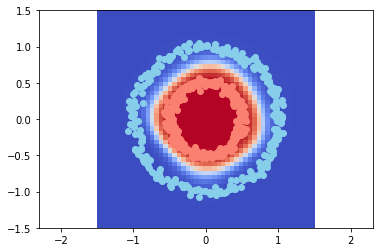

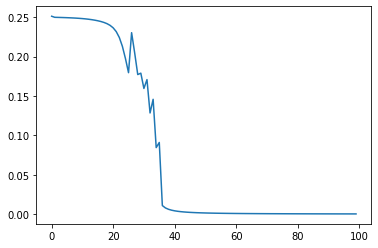

In [0]:
import time
from IPython.display import clear_output

topology = [p, 4, 8, 16, 1]
nn= createNeuralNetwork (topology, sigm, deriv_sigm)

# Se guardara los costes, para poder graficar como evoluciona
loss = []
for i in range(2500):
  Ypredicted = train (nn, X, Y, cost, deriv_cost, learning_rate= 0.01)
  if i%25==0:
    loss.append(cost(Ypredicted, Y))
    
    #cantidad de puntos, resolucion
    res = 50
    _x0=np.linspace(-1.5, 1.5, num=res)
    _x1=np.linspace(-1.5, 1.5, num=res)

    _Y = np.zeros((res,res))

    for i0, x0 in enumerate(_x0):
      for i1, x1 in enumerate(_x1):
        _Y[i0, i1] = train (nn, np.array([[x0, x1]]), Y, cost, deriv_cost, 0.05, train=False)[0][0]

    plt.pcolormesh(_x0, _x1, _Y, cmap="coolwarm")
    plt.axis("equal")

    # Plotear solo los puntos que pertenecen al circulo 0
    plt.scatter(X[Y[:,0]==0,0],X[Y[:,0]==0,1], c="skyblue")
    # Plotear solo los puntos que pertenecen al circulo 1
    plt.scatter(X[Y[:,0]==1,0],X[Y[:,0]==1,1], c="salmon")

    #Limpiar el contenido para mostrar de forma animada los resultados
    clear_output(wait=True)
    plt.show()
    plt.plot (range(len(loss)), loss)
    plt.show()
    time.sleep(0.5)
